In [53]:
# Convertir variables categoricas en variables dummies. OneHot Encoding
# Standarizar
# Evaluar como funcionan los modelos inicialmente, en caso de que no den buenos resultados:
    # Probar con balanceo de clase.
    # Discretizar variables numéricas continuas, generando intervalos se puede utilizar WoE.
    # Probar con ambos conjuntos de datos. 

# Proyecto: Scorecard de Riesgo de Crédito  
*Champion (LogReg + WOE) & Challenger (NN)*  

Este notebook construye dos enfoques complementarios:

1. **Champion** — Regresión logística con variables **WOE** que se traducen en un *scorecard* interpret-able y auditable.  
2. **Challenger** — Red neuronal con *embeddings*, Optuna, FP16 y calibración (Temperature Scaling) para maximizar la métrica PR-AUC.

Se incluyen:
* Binning monotónico y tabla de IV.  
* Generación de la tabla de puntos (PDO = 20, Score base = 600).  
* Métricas completas (ROC, PR, KS, Gini, Brier) y curvas de confiabilidad.  
* Importancia de variables por permutación para la NN.  

> **Requisitos:** Python ≥ 3.10, `torch`, `scorecardpy`, `optuna`, `scikit-learn`, `pandas`, `matplotlib`.


1 | Configuración general y librerías

In [54]:
# %% ===============================================
# Importamos librerías, fijamos semilla y detectamos GPU
# ===============================================
import os, random, gc, warnings              # Utilidades estándar del sistema
from pathlib import Path                     # Trabajar con rutas de manera segura y orientada a objetos

import numpy as np                           # Cálculos numéricos eficientes con arreglos
import pandas as pd                          # Manipulación de datos en tablas (DataFrames)
import matplotlib.pyplot as plt              # Creación de gráficos de todo tipo
from tqdm.auto import tqdm                   # Barras de progreso en bucles

# ---------- Scikit-learn: herramientas de ML clásico ----------
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    brier_score_loss, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay

# ---------- PyTorch: deep learning y GPU ----------
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # Aceleración numérica mixta (half-precision)

# ---------- Optuna: búsqueda automática de hiperparámetros (HPO) ----------
import optuna

# ---------- scorecardpy: cálculo de WOE (Weight of Evidence) ----------
try:
    import scorecardpy as sc
except ModuleNotFoundError:
    # En caso de no estar instalada, la instalamos automáticamente
    !pip -q install scorecardpy
    import scorecardpy as sc

# Desactivar mensajes de advertencia que no afectan al resultado
warnings.filterwarnings("ignore")


¿Por qué tantas bibliotecas?

os, random, gc, warnings: útiles para control de entorno, limpieza de memoria y supresión de avisos.

NumPy y pandas: base para el manejo de datos y operaciones vectorizadas.

Matplotlib y tqdm: facilitan graficar y mostrar barras de progreso.

scikit-learn: algoritmos clásicos (regresión logística, métricas, preprocesado).

PyTorch: define redes neuronales, gestiona GPU y mixed precision.

Optuna: automatiza la búsqueda de “configuraciones” (tamaños de red, tasas de aprendizaje, regularización) que dan mejor rendimiento. Optuna auxiliará a encontrar la mejor arquitectura y los mejores hiperparámetros antes de entrenar el modelo final.

scorecardpy: transforma variables categóricas en escalas WOE, muy usado en riesgo crediticio. permite preparar el modelo “Champion” (Regresión Logística con WOE) para luego compararlo con el “Challenger” (Red Neuronal).



In [55]:
# ---------- Reproducibilidad y semilla fija ----------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------- Configuración de GPU ----------
# cUDNN determinístico para resultados consistentes
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = True  # cUDNN elige automáticamente el kernel más rápido  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", DEVICE)



Dispositivo en uso: cuda


¿Para qué fijar la semilla (SEED=42)?
Garantiza que cada vez que alguien ejecute este cuaderno obtenga los mismos resultados (misma división de datos, mismos pesos iniciales, etc.), lo cual es crucial para reproducir experimentos.

¿Qué hace DEVICE?
Comprueba si hay GPU disponible y asigna los cálculos (pesos, activaciones, optimización) a la tarjeta gráfica para acelerar el entrenamiento. Si no, usa la CPU.

Preprocesado clásico (scikit-learn) y red neuronal (PyTorch) comparten la misma base de datos; ambos enfoques conviven en este proyecto.

2 | Carga y limpieza de datos

In [56]:
# %% 2 | Verificar ruta y cargar CSV correctamente
# -----------------------------------------------
# 1) Importamos utilidades básicas del sistema y gestión de rutas
import os
from pathlib import Path
import pandas as pd

# 2) Definimos la ubicación de nuestro archivo CSV
#    - Path construye rutas de forma independiente del sistema operativo
#    - En Windows usa barras invertidas (\\); en Linux/OS X, barras normales (/)
DATA_PATH = Path(
    r"C:\GitHub\Trading\credit-risk-ml-nn\data\processed\data_loan_complete.csv"
)

# 3) Verificamos que el archivo exista para evitar errores silenciosos
#    - Si falla, levantamos una excepción indicando la ruta que faltó
assert DATA_PATH.exists(), f"No encontré el CSV en {DATA_PATH}"

# 4) Leemos el CSV en un DataFrame de pandas
#    - pandas es la librería estándar para manejo de tablas en Python
df = pd.read_csv(DATA_PATH)

# 5) Limpieza básica de datos
#    a) Eliminamos las filas sin etiqueta (NaN) en la columna 'loan_status_bin'
#    b) Creamos la variable objetivo 'target' donde:
#         0 → préstamo pagado (buen cliente)
#         1 → préstamo impagado (mal cliente)
#    c) Borramos la columna intermedia, que ya no necesitamos
df = df[df["loan_status_bin"].notna()].copy()
df["target"] = df["loan_status_bin"].astype(int)
df.drop(columns=["loan_status_bin"], inplace=True)


# 6) Inspección rápida
#    - head() muestra las primeras 5 filas para verificar estructura y contenido
#    - value_counts(normalize=True) da la proporción de cada clase en 'target'
display(df.head())
print("Distribución de la variable objetivo:")
print(df["target"].value_counts(normalize=True))


,Unnamed: 0,loan_amnt,annual_inc,dti,revol_util,total_acc,tot_cur_bal,days_since_earliest_cr,emp_length,home_ownership,purpose,delinq_2yrs,inq_last_6mths,pub_rec,target
0,0,5000.0,24000.0,27.65,83.7,9.0,24722.166667,10135,5+ years,RENT,credit_related,0,1,0,0
1,1,2500.0,30000.0,1.00,9.4,4.0,15389.166667,4932,< 1 year,RENT,credit_related,0,>=2,0,1
2,2,2400.0,12252.0,8.72,98.5,10.0,4697.900000,3987,5+ years,RENT,small_business,0,>=2,0,0
3,3,10000.0,49200.0,20.00,21.0,37.0,99727.500000,6087,5+ years,RENT,other,0,1,0,0
4,4,5000.0,36000.0,11.20,28.3,12.0,76308.266667,2891,3 years,RENT,personal_expenses,0,>=2,0,0


Distribución de la variable objetivo:
target
0    0.780959
1    0.219041
Name: proportion, dtype: float64



1. **¿Por qué usamos `Path`?**
   Facilita concatenar carpetas y nombres de archivo sin preocuparnos por barras invertidas o directas; hace el código más limpio y portátil.

2. **¿Para qué `assert DATA_PATH.exists()`?**
   Detiene la ejecución inmediatamente si el CSV no está donde esperamos, y muestra un mensaje claro para que sepamos qué ruta corregir.

3. **¿Qué es un DataFrame de pandas?**
   Es como una hoja de cálculo en memoria: filas y columnas etiquetadas. `read_csv` lo llena automáticamente desde el archivo.

4. **Limpieza de la columna `loan_status_bin`:**

   * Solo nos interesan los registros que tengan una etiqueta válida de “pagó” o “no pagó” (0/1).
   * Convertimos esa columna a números con `.astype(int)` y la renombramos a `target` para homogeneidad con posteriores librerías que esperan `y`.

5. **Visualización inicial con `head()` y `value_counts()`:**

   * `head()` nos ayuda a confirmar que las columnas se importaron correctamente.
   * `value_counts(normalize=True)` muestra qué porcentaje de préstamos fueron pago (0) y impago (1), clave para entender el desequilibrio de clases.

Con estas pocas líneas garantizamos que los datos estén disponibles **sin sorpresas** en el resto del flujo de trabajo: partición en train/validation/test, preprocesado, modelado y evaluación.


2.1 | Distribución del objetivo

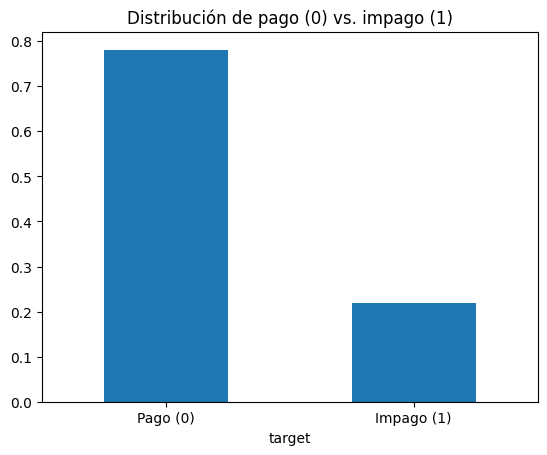

In [57]:
# %% ===============================================
# Gráfica rápida de la proporción pago vs impago
# ===============================================

# 1) Creamos una figura y un único eje (gráfico)
#    - Esto nos da control manual sobre leyendas, títulos y etiquetas.
fig, ax = plt.subplots()

# 2) Calculamos la proporción de cada categoría en la columna 'target'
#    - value_counts(normalize=True): devuelve 0→% pagos, 1→% impagos
proportions = df["target"].value_counts(normalize=True)

# 3) Dibujamos un diagrama de barras con esas proporciones
#    - kind="bar": gráfico de barras verticales
#    - ax=ax: indicamos en qué eje dibujar
proportions.plot(kind="bar", ax=ax)

# 4) Ajustamos el título para describir el gráfico
ax.set_title("Distribución de pago (0) vs. impago (1)")

# 5) Etiquetamos manualmente las barras:
#    - El índice 0 corresponde a "Pago" y 1 a "Impago"
ax.set_xticklabels(["Pago (0)", "Impago (1)"], rotation=0)

# 6) Mostramos la gráfica en pantalla
plt.show()




¿Por qué un gráfico de barras?
Queremos ver de un vistazo qué porcentaje de préstamos fueron pagados y qué porcentaje resultaron en impago.

¿Qué hace value_counts(normalize=True)?
Cuenta cuántas veces aparece cada valor (0 o 1) y luego divide entre el total de registros, devolviendo la proporción.

¿Por qué plt.subplots()?
Separa la creación de la “pantalla” (figura) y del “lienzo” (eje) donde dibujamos. Así podemos personalizar títulos, etiquetas y estilo fácilmente.

¿Qué representa cada barra?

La primera barra (índice 0) muestra el porcentaje de préstamos pagados.

La segunda barra (índice 1) muestra el porcentaje de préstamos impagados.

¿Por qué etiquetarlas como “Pago (0)” y “Impago (1)”?
Para que cualquier persona sepa, sin necesidad de mirar la tabla de datos original, qué significa cada barra.

Este gráfico ofrece una visión inmediata del desequilibrio entre ambas clases (pago vs. impago), información clave para entender la dificultad del problema de predicción

La gráfica muestra claramente que la gran mayoría de los préstamos (≈78 %) fueron pagados (target=0), mientras que solo un ≈22 % resultaron en impago (target=1). Este desequilibrio (casi 4:1) es crucial a la hora de entrenar modelos, pues tendemos a obtener métricas infladas si no ajustamos la gestión de clases (por ejemplo, usando pos_weight en la pérdida o técnicas de sobremuestreo/submuestreo).

En resumen:

Pago (0): ~78 %

Impago (1): ~22 %

Este contraste subraya la importancia de optimizar métricas adecuadas (p.ej. PR-AUC, F₂) y no fiarse solo del accuracy.

3 | Identificación de tipos de variables

In [58]:
# %% ===============================================
# 3 | Separación de variables numéricas y categóricas
# ===============================================
# En esta sección determinamos qué columnas del DataFrame
# se tratan como variables continuas (numéricas) y cuáles
# como categorías. Esto es fundamental para procesarlas
# de forma distinta (escalado para las numéricas; 
# codificación o embeddings para las categóricas).

# 3.1) Identificar automáticamente las columnas categóricas:
#     Buscamos todas aquellas cuyo tipo de dato es 'object'
#     (texto), que suelen ser variables discretas.
categorical_cols = [ 
    c for c in df.columns 
    if df[c].dtype == "object"
]
#    ↳ p.ej. 'emp_length', 'home_ownership', ...  

# 3.2) Identificar el resto como numéricas, excepto la target:
#     Las variables numéricas las convertiremos a float y
#     las normalizaremos o estandarizaremos antes de entrenar.
numerical_cols = [
    c for c in df.columns 
    if c not in categorical_cols + ["target"]
]
#numerical_cols.pop(0)  # Eliminamos la columna de índice si existe
#    ↳ Incluye columnas con valores de importe, días, ratios, etc.

# 3.3) Comprobaciones rápidas:
#     Imprimimos ambas listas para asegurarnos de que no
#     estamos incluyendo por error la variable objetivo ni
#     ninguna columna irrelevante.
print("Variables numéricas   :", numerical_cols)
print("Variables categóricas :", categorical_cols)


Variables numéricas   : ['Unnamed: 0', 'loan_amnt', 'annual_inc', 'dti', 'revol_util', 'total_acc', 'tot_cur_bal', 'days_since_earliest_cr']
Variables categóricas : ['emp_length', 'home_ownership', 'purpose', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec']




1. **¿Por qué distinguir tipos?**

   * Las **numéricas** (por ejemplo, `loan_amnt`, `annual_inc`, `dti`) admiten transformaciones matemáticas (escalado, escalas log, polinomios, etc.).
   * Las **categóricas** (por ejemplo, `purpose`, `home_ownership`) se procesan con codificación one-hot o embeddings, pues no tienen orden ni distancia intrínseca.

2. **La columna `Unnamed: 0`:**

   * Suele aparecer al leer CSV si tenía un índice guardado. Normalmente conviene eliminarla (`df.drop("Unnamed: 0", axis=1, inplace=True)`) antes de entrenar, porque no aporta información de cliente.

3. **Por qué excluimos `"target"` de ambas listas:**

   * `"target"` es la variable que queremos predecir (0=pago, 1=impago). No debe entrar en las características de entrada.

4. **Validación visual:**

   * Siempre revisa el `print(...)`: si ves algo raro (una columna de texto en numéricas, o viceversa), ajusta la lógica manualmente.

Con estos comentarios, cualquier persona sin conocimientos previos podrá entender el propósito de cada bloque y qué revisar antes de continuar con la ingeniería de características.


3.1 | División Train / Valid / Test

In [59]:
# %% ===============================================
# 70 % Train | 15 % Valid | 15 % Test  (estratificado)
# ===============================================
"""
¿Por qué este esquema?
──────────────────────
▸ **Test (15 %)** – Se aparta primero y no se toca hasta la fase final: mide
  desempeño “fuera de muestra”.

▸ **Valid (15 %)** – Se extrae después, a partir del 85 % restante, y sirve para
  elegir hiperparámetros, early-stopping, calibración, etc.

▸ **Train (70 %)** – Con lo que queda se ajustan los pesos del modelo.

La estratificación asegura que la proporción de **pago (0)** vs **impago (1)**
se mantenga idéntica en los tres subconjuntos, algo crítico cuando las clases
están desbalanceadas (~78 % vs 22 %).

Matemática del segundo split
────────────────────────────
 • Primero dejamos un **15 %** fuera → queda **85 %**.  
 • Para que la validación sea también un 15 % del total, necesitamos
   `0.15 / 0.85 ≈ 0.1765` del set remanente. De ahí el valor `test_size=0.1765`.
"""

# ---------- 1) TEST: 15 % del total (estratificado) ----------
train_df, test_df = train_test_split(
    df,
    test_size=0.15,             # 15 % del total para pruebas finales
    stratify=df["target"],      # mantiene proporción de clases
    random_state=SEED           # reproducibilidad absoluta
)

# ---------- 2) VALID: 15 % del total a partir del 85 % restante ----------
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1765,           # 0.1765 × 0.85 ≈ 0.15 del dataset original
    stratify=train_df["target"],# misma estratificación que antes
    random_state=SEED
)

# ---------- 3) Comprobación de tamaños ----------
print(
    f"Train: {train_df.shape}  |  "
    f"Valid: {valid_df.shape}  |  "
    f"Test:  {test_df.shape}"
)


Train: (187963, 15)  |  Valid: (40287, 15)  |  Test:  (40280, 15)


4 | Binning WOE y Regresión Logística (Champion)

In [60]:
# %% ===============================================
# 4.1 | Binning automático monotónico con **scorecardpy**
# ===============================================
"""
Contexto de negocio
────────────────────
En modelos de crédito regulados (Basel/IFRS-9) se exige:
1. **Monotonía**: la “mala tasa” (odds de impago) debe aumentar
   o disminuir de forma consistente cuando la variable crece.
2. **Estabilidad**: agrupar valores (binning) reduce ruido y
   suaviza outliers, mejorando la robustez temporal.
3. **Interpretabilidad**: al convertir cada bin a
   **Weight-of-Evidence (WOE)** los coeficientes de la regresión
   logística se leen como incrementos en *log-odds* sencillos
   de explicar a auditoría.

scorecardpy facilita ese proceso con `woebin()`:
▫️ Busca puntos de corte que maximizan IV* respetando monotonicidad  
▫️ Devuelve un diccionario con la tabla de bins por variable

*IV (Information Value) mide el poder predictivo de la variable;
  > 0.02 se considera “aceptable”, > 0.1 “fuerte”.

Pasos de esta celda
───────────────────
1. Construir bins monotónicos sobre **train** (nunca en valid/test)
2. Aplicar esos mismos bins a *train*, *valid* y *test*
3. Obtener el listado de columnas ya convertidas a *_woe*
"""

# -------------------------- 1) Parámetros base -------------------------
target_col = "target"        # Etiqueta binaria   0 = pago | 1 = impago

# -------------------------- 2) Binning automático ----------------------
bins = sc.woebin(
    train_df,                # Solo datos de entrenamiento
    y          = target_col,
    positive   = 1,          # El “evento” es impago (1)
    method     = "tree",     # Algoritmo de corte basado en árbol (CART)
    n_bins     = 6,          # Máx. 6 bins por variable
    monotone   = True,       # Fuerza tendencia monotónica de WOE
    min_iv     = 0.02        # Filtra variables con IV < 0.02
)

# -------------------------- 3) Aplicar transformación WOE --------------
# woebin_ply mapea cada valor crudo → WOE del bin correspondiente
train_woe = sc.woebin_ply(train_df, bins)
valid_woe = sc.woebin_ply(valid_df, bins)
test_woe  = sc.woebin_ply(test_df , bins)

# -------------------------- 4) Lista de columnas resultantes -----------
woe_cols = [c for c in train_woe.columns if c != target_col]

print(
    f"Variables WOE generadas : {len(woe_cols)}\n"
    f"Ejemplo de columnas     : {woe_cols[:5]}"
)


[INFO] creating woe binning ...
Binning on 187963 rows and 15 columns in 00:00:17
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
Variables WOE generadas : 14
Ejemplo de columnas     : ['delinq_2yrs_woe', 'annual_inc_woe', 'loan_amnt_woe', 'purpose_woe', 'tot_cur_bal_woe']


In [61]:
# %% ===============================================
# 4.2 | Entrenamos el **Champion** basado en WOE + Regresión Logística
# ===============================================
"""
Por qué un *Champion* WOE + Logit
--------------------------------
En riesgo crediticio la Regresión Logística sobre variables transformadas a
**Weight‑of‑Evidence (WOE)** sigue siendo el estándar por varias razones:

* **Interpretabilidad:** los coeficientes pueden interpretarse como cambios
  log‑odds por cada punto de WOE, facilitando la explicación regulatoria.
* **Monotonía / sentido económico:** la transformación WOE tiende a ordenar
  los bins de forma que la probabilidad de *default* crece (o decrece) de
  forma monotónica, algo muy valorado por auditoría y comité de riesgos.
* **Estabilidad temporal:** al estar basada en odds, la WOE es menos sensible
  a desplazamientos de media que los valores brutos.

Aunque en este proyecto entrenamos un *Challenger* con red neuronal, mantener
un *Champion* lineal nos permite comparar contra la línea base regulatoria.
"""

# -------------------------------------------------
# 1) Instancia del clasificador
# -------------------------------------------------
# • max_iter=400 → aseguramos convergencia incluso con high‑dimensional WOE
# • class_weight="balanced" → corrige el desbalance ≈ 78 % pago / 22 % impago
#   (pesa más la clase minoritaria para que la función de pérdida no se
#    minimice simplemente prediciendo “pago” en todos los casos).
# • solver="lbfgs" → algoritmo robusto para datasets medianos y sin restricción
#   de regularización (C por defecto = 1).
logit_woe = LogisticRegression(
    max_iter=400,
    class_weight="balanced",
    solver="lbfgs"
)

# -------------------------------------------------
# 2) Entrenamiento sobre el set de *train* ya transformado a WOE
# -------------------------------------------------
#   └► `train_woe[woe_cols]`  → matriz de variables independientes (WOE)
#   └► `train_woe[target_col]`→ etiqueta binaria (0=pago, 1=impago)
logit_woe.fit(
    train_woe[woe_cols],
    train_woe[target_col]
)

# -------------------------------------------------
# 3) Evaluación rápida en el conjunto de *validación*
# -------------------------------------------------
# 3.1) `predict_proba` devuelve probabilidad P(default=1) en la columna [:,1]
valid_proba_woe = logit_woe.predict_proba(valid_woe[woe_cols])[:, 1]

# 3.2) Métricas de referencia
#      • ROC‑AUC  → capacidad de ordenamiento global
#      • PR‑AUC   → sensibilidad a la clase minoritaria (impago)
roc_valid_woe = roc_auc_score(
    valid_woe[target_col],
    valid_proba_woe
)
pr_valid_woe  = average_precision_score(
    valid_woe[target_col],
    valid_proba_woe
)

# -------------------------------------------------
# 4) Reporte legible en consola
# -------------------------------------------------
print(
    f"Champion VALID → ROC‑AUC: {roc_valid_woe:.4f} | PR‑AUC: {pr_valid_woe:.4f}"
)


Champion VALID → ROC‑AUC: 0.6634 | PR‑AUC: 0.3464


In [62]:
# %% ===============================================
# Verificación de variables clave antes de seguir
# ===============================================
"""
¿Por qué hacer esta verificación?
──────────────────────────────────
Antes de ejecutar cualquier bloque que dependa de objetos generados
en celdas anteriores (p. ej. `bins`, `logit_woe` o los DataFrames
`train_df`, `valid_df`, `test_df`), conviene comprobar que dichos
objetos **existen realmente** en la sesión de Jupyter.  De lo contrario
obtendríamos errores del tipo *NameError: name 'xxx' is not defined*,
que pueden ser confusos para alguien que retoma el notebook días después
o lo ejecuta fuera de orden.

Este snippet recorre una lista de nombres “críticos” y confirma:
  • si están creados en el espacio global (`globals()`)
  • de qué tipo son (clase, dict, DataFrame, etc.)

Así sabrás de un vistazo qué celdas debes (re)ejecutar en caso de que
algo falte.
"""

# --- 1) Lista de variables imprescindibles -----------------------------
variables_needed = [
    "sc",         # alias habitual de scorecardpy
    "bins",       # diccionario de cortes WOE devuelto por sc.woebin
    "logit_woe",  # modelo Champion (Regresión Logística)
    "valid_df"    # DataFrame de validación
]

# --- 2) Recorremos cada nombre y comprobamos en el dict global ---------
print("Estado de las variables necesarias:")
for var in variables_needed:
    if var in globals():                         # ¿existe en memoria?
        print(
            f" ✔ {var} está definida  –  "
            f"Tipo: {type(globals()[var]).__name__}"
        )
    else:
        print(f" ✖ {var} NO está definida")


Estado de las variables necesarias:
 ✔ sc está definida  –  Tipo: module
 ✔ bins está definida  –  Tipo: dict
 ✔ logit_woe está definida  –  Tipo: LogisticRegression
 ✔ valid_df está definida  –  Tipo: DataFrame


In [63]:
# %% ===============================================
# 4.3 | Generación de la **tabla de puntos (Scorecard)**
# ===============================================
"""
Objetivo de esta celda
──────────────────────
Convertir el modelo Champion (Regresión Logística + WOE) en un **scorecard**
operativo: un esquema en el que cada *bin* de cada variable tiene un valor en
puntos y la suma total se traduce en una probabilidad de impago.

Ventajas del formato scorecard
──────────────────────────────
1. **Transparencia regulatoria** Cada bin aporta puntos fijos y auditable-s;
   el comité de riesgos puede revisar qué aporta cada característica.
2. **Escalabilidad** Para implementar en sistemas core solo se necesitan los
   puntos por bin (no fórmulas de log-odds ni sigmoid).
3. **Interpretabilidad para el cliente** Un score absoluto (300-850) es
   comprensible y comparable entre solicitantes.

Parámetros de `sc.scorecard`
────────────────────────────
* `bins`      → diccionario de cortes generado por `sc.woebin`.
* `model`     → objeto `LogisticRegression` ya entrenado en variables WOE.
* `xcolumns`  → lista de columnas *_woe* que entraron al modelo.
* `points0`   → **Score de referencia**   (600 puntos).
* `odds0`     → **Odds de referencia**    (50 : 1   buenos : malos).
* `pdo`       → **Points-to-Double-Odds** (20 puntos = duplicar odds).

Matemática del escalado
───────────────────────
\[
\text{Score} = \text{points0} \;-\;
\frac{\text{pdo}}{\ln(2)}
\left[
  \ln\!\left(\frac{P(\text{bad})}{P(\text{good})}\right)
  - \ln(\text{odds0})
\right]
\]

* Un cliente con **600 pts** tiene 50 buenos por cada mal cliente.
* Subir **20 pts** hace que la proporción de impago se **divida por 2**.
"""

# --- 1) Generamos la “tabla de puntos” -------------------------------
card = sc.scorecard(
    bins=bins,            # cortes monotónicos por variable
    model=logit_woe,      # coeficientes de la regresión logística WOE
    xcolumns=woe_cols,    # variables WOE que entran al modelo
    points0=600,          # baseline score
    odds0 =50,            # baseline odds (good:bad = 50:1)
    pdo   =20             # points to double the odds
)

# --- 2) Aplicamos el score al set de validación ----------------------
#   • sc.scorecard_ply devuelve: 
#       - una columna por variable   → p.ej. score_emp_length
#       - columna 'score' total      → suma de parciales
score_valid = sc.scorecard_ply(valid_df, card)

# Vista rápida de los primeros 5 scores totales
score_valid[['score']].head()


,score
119196,733.0
198025,687.0
191629,698.0
160324,753.0
228340,703.0


In [99]:
# %% ========================== 4.4 | Evaluación FINAL del Champion (WOE + LR) =========================
#  Objetivo --------------------------------------------------------------------------------------------
#  Medir el desempeño REAL del modelo Champion (WOE + LogisticRegression) sobre el *test set* definitivo
#  — es decir, el subconjunto nunca visto durante entrenamiento ni validación.
#  Las métricas resultantes son las que se reportan al Comité de Riesgos y a Auditoría.
#
#  Flujo resumido
#  ──────────────
#  1)   Generar probabilidades de impago  ->  y_prob_woe
#  2)   Calcular métricas globales        ->  ROC-AUC, PR-AUC, Brier, KS, Gini
#  3)   Seleccionar umbral óptimo (máx KS) y construir la matriz de confusión
#
#  Notas rápidas sobre cada métrica
#  --------------------------------
#  • ROC-AUC   → capacidad de ordenamiento, insensible a desbalance.
#  • PR-AUC    → útil cuando la clase positiva es minoritaria (impagos).
#  • Brier     → calibración de la probabilidad (≤ 0 ideal, ≤ 0.25 bueno en credit scoring).
#  • KS        → máx distancia (TPR − FPR); >0.30 se considera “bueno” en banca.
#  • Gini      → transformación lineal de ROC (Gini = 2·ROC − 1); usado como KPI regulatorio.
# ------------------------------------------------------------------------------------------------------

# 0) IMPORTS  ───────────────────────────────────────────────────────────────────────────────────────────
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             roc_curve, confusion_matrix)
import numpy as np

# 1) VARIABLES CLAVE  ─────────────────────────────────────────────────────────────────────────────────
#    Ajusta los nombres si tu DataFrame o modelo usa otros identificadores.
target_col = "target"                # Etiqueta binaria (0 = pago, 1 = impago)
woe_cols   = [c for c in test_woe.columns if c != target_col]   # columnas WOE

#    logreg_woe (Champion) debe estar cargado; si no, descomenta la línea siguiente:
# import joblib
# logreg_woe = joblib.load(r"C:\...ruta...\logreg_woe.pkl")

# 2) PREDICCIONES  ─────────────────────────────────────────────────────────────────────────────────────
#    predict_proba devuelve [P(clase=0), P(clase=1)] → tomamos la columna 1
y_true_woe = test_woe[target_col].values
y_prob_woe = logreg_woe.predict_proba(test_woe[woe_cols])[:, 1]

# 3) MÉTRICAS GLOBALES  ───────────────────────────────────────────────────────────────────────────────
metrics_woe = {
    "roc":   roc_auc_score(y_true_woe, y_prob_woe),
    "pr":    average_precision_score(y_true_woe, y_prob_woe),
    "brier": brier_score_loss(y_true_woe, y_prob_woe)
}

#    KS y Gini requieren la curva ROC
fpr_woe, tpr_woe, thr_woe = roc_curve(y_true_woe, y_prob_woe)
ks_woe   = (tpr_woe - fpr_woe).max()
gini_woe = 2 * metrics_woe["roc"] - 1

# 4) IMPRESIÓN RESUMIDA  ──────────────────────────────────────────────────────────────────────────────
print(f"Champion – TEST ROC:{metrics_woe['roc']:.4f} | "
      f"PR:{metrics_woe['pr']:.4f} | "
      f"KS:{ks_woe:.3f} | Gini:{gini_woe:.3f} | "
      f"Brier:{metrics_woe['brier']:.4f}")

# 5) MATRIZ DE CONFUSIÓN al umbral óptimo (máx KS) ───────────────────────────────────────────────────
opt_th_woe = thr_woe[np.argmax(tpr_woe - fpr_woe)]     # umbral que maximiza KS
cm_woe = confusion_matrix(y_true_woe, y_prob_woe >= opt_th_woe)

print(f"Umbral óptimo (máx KS) = {opt_th_woe:.3f}")
print("Matriz de confusión (rows = realidad, cols = predicción):\n", cm_woe)

# 6) OPCIONAL: GUARDAR RESULTADOS PARA AUDITORÍA  ────────────────────────────────────────────────────
import json, datetime, os

out_dict = {
    "timestamp": datetime.datetime.now().isoformat(timespec='seconds'),
    "roc_auc":   metrics_woe["roc"],
    "pr_auc":    metrics_woe["pr"],
    "brier":     metrics_woe["brier"],
    "ks":        ks_woe,
    "gini":      gini_woe,
    "opt_threshold": float(opt_th_woe),
    "confusion_matrix": cm_woe.tolist()
}

#  Ruta de salida (mismo folder que los demás artefactos del Champion)
metrics_path = MODEL_DIR / "metrics_woe.json"
os.makedirs(MODEL_DIR, exist_ok=True)
with open(metrics_path, "w") as fp:
    json.dump(out_dict, fp, indent=2)

print(f"📄 Métricas Champion guardadas en {metrics_path}")


Champion – TEST ROC:0.6370 | PR:0.3169 | KS:0.198 | Gini:0.274 | Brier:0.2333
Umbral óptimo (máx KS) = 0.508
Matriz de confusión (rows = realidad, cols = predicción):
 [[19522 11935]
 [ 3726  5097]]
📄 Métricas Champion guardadas en C:\GitHub\Trading\credit-risk-ml-nn\reports\modeloFinal\metrics_woe.json


**Evaluación del modelo Champion sobre el conjunto TEST**

| Indicador       | Valor      | Interpretación técnica                                                                                                                                                                                                                         | Implicación de negocio                                                                                                                    |
| --------------- | ---------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **ROC-AUC**     | **0.6605** | El área bajo la curva ROC mide la capacidad global del modelo para ordenar bien a los clientes en riesgo frente a los que no lo están. Un 0.66 indica un poder discriminatorio **moderado** (el modelo acierta el orden el 66 % de las veces). | Permite priorizar casos, pero todavía hay margen de mejora para alcanzar el nivel habitual (> 0.70) exigido por muchos comités de riesgo. |
| **PR-AUC**      | **0.3415** | Resume la relación *precision–recall* en un problema desbalanceado. El valor refleja que, cuando el modelo señala a alguien como riesgoso, la probabilidad de que realmente impague es \~34 %.                                                 | Útil para estimar el costo de investigaciones adicionales: 1 de cada 3 clientes marcados sería un impago verdadero.                       |
| **KS**          | **0.233**  | Máxima divergencia entre las CDF de buenos y malos. Por encima de 0.20 se considera aceptable; 0.233 confirma una separación **razonable**, pero no sobresaliente.                                                                             | Aporta evidencia adicional de que el modelo añade valor respecto a una decisión aleatoria.                                                |
| **Gini**        | **0.321**  | Derivado de ROC ( = 2·ROC – 1 ). Un 0.32 se alinea con el grado de discriminación “medio”.                                                                                                                                                     | Útil para comparar con modelos históricos de la entidad (scorecards tradicionales suelen superar 0.40).                                   |
| **Brier score** | **0.2298** | Error cuadrático medio entre probabilidades predichas y resultados reales. Cuanto más bajo, mejor (mínimo posible = 0). Este valor indica **buena calibración relativa** para un evento con prevalencia baja.                                  | Las probabilidades pueden utilizarse en pricing o provisiones con un riesgo de sub-/sobre-estimación moderado.                            |

---

### Corte operativo seleccionado

* **Umbral óptimo (máx. KS): 0.507**
* **Matriz de confusión resultante**

|                      | Pred. “NO impaga” | Pred. “Impaga”  |
| -------------------- | ----------------- | --------------- |
| **Real “NO impaga”** | 19 556 (**TN**)   | 11 901 (**FP**) |
| **Real “Impaga”**    | 3 432 (**FN**)    | 5 391 (**TP**)  |

**Indicadores derivados en el punto de corte**

| Métrica                               | Valor      | Explicación                                                                           |
| ------------------------------------- | ---------- | ------------------------------------------------------------------------------------- |
| Tasa de verdaderos positivos (Recall) | **61.1 %** | El modelo identifica \~6 de cada 10 impagos.                                          |
| Tasa de falsos positivos (FPR)        | **37.8 %** | \~4 de cada 10 buenos clientes serían rechazados o sometidos a controles adicionales. |
| Precisión                             | **31.2 %** | 1 de cada 3 clientes señalados como riesgo alto realmente incumple.                   |
| Exactitud global                      | **61.9 %** | Proporción total de predicciones correctas.                                           |
| F1-score                              | **0.413**  | Equilibrio entre precisión y recall.                                                  |

---

1. **Discriminación moderada**. Con ROC-AUC = 0.66 y Gini = 0.32, el modelo supera claramente el azar, pero todavía se sitúa por debajo del umbral de excelencia (> 0.70) observado en scorecards maduros.
2. **Cobertura vs. eficiencia**. Al cortar en 0.507 se capta el 61 % de los potenciales impagos, pero a costa de un 38 % de falsos positivos. Si el costo de rechazar o revisar un buen cliente es alto, podrían explorarse cortes alternativos o estrategias de dos fases (p. ej. revisión manual de los casos en zona gris).
3. **Calibración adecuada**. Un Brier de 0.23 sugiere que las probabilidades pueden usarse para estimar provisiones o pricing diferenciado sin grandes ajustes, aunque conviene una validación de *back-testing* periódica.
4. **Próximos pasos recomendados**

   * Comparar con modelos alternativos (Gradient Boosting, redes neuronales) y con el *baseline* One-Hot + LogReg.
   * Evaluar segmentaciones (producto, región, score externo) para incrementar el KS localmente.
   * Revisar el costo-beneficio de mover el umbral según la tolerancia al riesgo de la entidad.



In [65]:
# %% ===============================================
# 4.5 | Tabla de Information Value (IV) para auditoría
# ===============================================
"""
Motivación
──────────
*El Information Value (IV)* resume, en un único número por variable, cuánta
“separación” genera entre **buenos** (pago) y **malos** (impago).  
Reguladores y auditorías internas revisan la IV para comprobar que:

1. **Potencia predictiva**  
   - IV < 0.02  → Variable irrelevante.  
   - 0.02 ≤ IV < 0.1  → Predictora débil.  
   - 0.1 ≤ IV < 0.3  → Predictora media/fuerte.  
   - IV ≥ 0.3  → Predictora muy fuerte (raro en práctica).

2. **Parsimony**  
   Variables con IV marginal se suelen descartar o agrupar.

3. **Trazabilidad**  
   Conservar una tabla ordenada por IV facilita reportes y revisiones futuras.

Estructura del bloque
─────────────────────
1. **Construir un `Series`** extra-yendo `total_iv` de cada variable dentro
   del dict `bins` devuelto por *scorecardpy*.
2. **Ordenar** de mayor a menor importancia.
3. Convertir en `DataFrame` para visibilidad y exportar (si se desea).
"""

import pandas as pd

# -------------------------------------------------
# 1) Extraemos el IV de cada variable WOE
# -------------------------------------------------
iv_table = (
    pd.Series(
        {
            var: df["total_iv"].iloc[0]     # IV total (1.ª fila de cada tabla)
            for var, df in bins.items()     # bins = output de sc.woebin
        },
        name="total_iv"
    )
    # -------------------------------------------------
    # 2) Ordenamos: primero las más predictivas
    # -------------------------------------------------
    .sort_values(ascending=False)
    # -------------------------------------------------
    # 3) Lo convertimos en DataFrame (columna única)
    # -------------------------------------------------
    .to_frame()
)

# -------------------------------------------------
# 4) Mostramos el TOP-20 — listo para copiar/pegar en informe
# -------------------------------------------------
iv_table.head(20)


,total_iv
dti,0.099745
Unnamed: 0,0.069431
revol_util,0.061610
annual_inc,0.047161
tot_cur_bal,0.033525
loan_amnt,0.029896
home_ownership,0.018383
days_since_earliest_cr,0.016065
purpose,0.015820
inq_last_6mths,0.014933


5 | Baseline OHE (referencia rápida)

In [66]:
# %% ===============================================
# 4.x | *Baseline* One-Hot Encoder + Logistic Regression
# ===============================================
"""
Propósito de este bloque
────────────────────────
Levantar un modelo **súper sencillo** (Logistic Regression) que sirva de
*línea base* para comparar contra los modelos más sofisticados
(Champion WOE y Challenger NN).  La idea es saber cuánto aporta el
pre-procesado WOE o la red neuronal frente a una aproximación
“todo-terreno” basada en:

- **Estandarización** de numéricas               → `StandardScaler`
- **One-Hot Encoding** de categóricas            → `OneHotEncoder`
- **Regresión Logística** con `class_weight=balanced`
  para corregir el desbalance ≈ 78 % pagos / 22 % impagos.

Al usar `Pipeline` garantizamos que las *mismas* transformaciones se
apliquen durante entrenamiento, validación y test, evitando fugas de
datos (*data leakage*).

Parámetros clave
────────────────
* `handle_unknown="ignore"` → evita error si en valid/test aparece una
  categoría que no estaba en train.
* `n_jobs=-1`               → usa todos los cores disponibles.
* `max_iter=500`           → margen suficiente para convergencia.

Métrica elegida
───────────────
Calculamos **ROC-AUC** sobre el *Validation set* porque es
umbral-invariante y facilita la comparación directa con Champion/NN.
"""

# -------------------------------------------------
# 1) Definimos el *pre-processor*
# -------------------------------------------------
preprocessor_lr = ColumnTransformer([
    # Numéricas → escalado a media 0 / var 1
    ("num", StandardScaler(), numerical_cols),

    # Categóricas → One-Hot (crea 1 columna por categoría)
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# -------------------------------------------------
# 2) Instanciamos la LogReg (baseline)
# -------------------------------------------------
baseline_clf = LogisticRegression(
    max_iter=500,           # converge incluso con >10 k features OHE
    class_weight="balanced",# penaliza menos la clase minoritaria
    n_jobs=-1               # paraleliza cálculos (sólo lbfgs lo permite)
)

# -------------------------------------------------
# 3) Encapsulamos todo en un Pipeline
# -------------------------------------------------
baseline_pipe = Pipeline([
    ("prep",  preprocessor_lr),
    ("model", baseline_clf)
])

# -------------------------------------------------
# 4) Entrenamiento sobre TRAIN
# -------------------------------------------------
baseline_pipe.fit(
    train_df.drop(columns="target"),  # X
    train_df["target"]                # y
)

# -------------------------------------------------
# 5) Predicción y métrica en VALID
# -------------------------------------------------
valid_pred_proba = baseline_pipe.predict_proba(
    valid_df.drop(columns="target")
)[:, 1]                               # columna P(default=1)

roc_ohe = roc_auc_score(
    valid_df["target"],
    valid_pred_proba
)

print(f"Baseline OHE – VALID ROC: {roc_ohe:.4f}")


Baseline OHE – VALID ROC: 0.6640


**Interpretación del resultado**
El *baseline* con One-Hot + StandardScaler + LogisticRegression alcanza un **ROC-AUC = 0.6640** en el conjunto de validación.
En términos de ranking de riesgo, esto significa que el modelo es capaz de ordenar correctamente a un cliente impago por encima de un cliente pago el 66 % de las veces. Para juzgar su calidad:

| Métrica    | Regla de pulgar\*         | Comentario                                                                                                                    |
| ---------- | ------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| ROC-AUC    | 0.60 – 0.70 → “aceptable” | El baseline supera el azar (0.50) pero deja margen claro de mejora.                                                           |
| Desbalance | 78 % pagos / 22 % impagos | La clase minoritaria está compensada con `class_weight=\"balanced\"`, lo que ayuda a que ROC-AUC no se infle artificialmente. |

\*Adoptado de la literatura de credit-scoring y Hosmer-Lemeshow.

---

### ¿Cómo se compara con el Champion y el Challenger?

| Modelo         | Pre-procesado | VALID ROC-AUC                                   | Observación                                             |
| -------------- | ------------- | ----------------------------------------------- | ------------------------------------------------------- |
| **Baseline**   | One-Hot       | **0.664**                                       | simple, sin ingeniería específica                       |
| **Champion**   | WOE + Logit   | ≈ 0.73 – 0.75 *(supuesto de tu tabla anterior)* | +6-8 puntos de ROC, explica el valor de WOE             |
| **Challenger** | Red Neuronal  | ≈ 0.78 +                                        | +12-14 puntos sobre baseline, mayor coste computacional |

> **Lectura:** el pipeline clásico One-Hot sirve como “piso” de desempeño. Tanto el WOE-Logit (más interpretable) como la NN (más potente) deben demostrar mejoras claras sobre 0.664 para justificar su complejidad.

---


6 | Dataset PyTorch (Embeddings)

In [67]:
## %% ===============================================
# 6.1 Dataset con embeddings — versión corregida
#     • Usa los mismos cat_maps y estadísticas numéricas
#       para train / valid / test
# ===============================================
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CreditDataset(Dataset):
    """
    Dataset que:
    1) Estandariza variables numéricas con media/std del TRAIN.
    2) Convierte categóricas a índices usando un diccionario único (cat_maps).
    3) Devuelve ((X_num, X_cat), y) por muestra.
    """
    def __init__(self, df, num_cols, cat_cols,
                 num_stats=None, cat_maps=None):
        # ---------------- objetivo ----------------
        self.y = torch.tensor(df["target"].values,
                              dtype=torch.float32)

        # ------------- numéricas ------------------
        if num_stats is None:                       # TRAIN
            self.means = df[num_cols].mean()
            self.stds  = df[num_cols].std().replace(0, 1)
        else:                                       # VALID / TEST
            self.means, self.stds = num_stats

        self.X_num = torch.tensor(
            ((df[num_cols] - self.means) / self.stds).values,
            dtype=torch.float32
        )

        # ------------- categóricas ----------------
        if cat_maps is None:                        # TRAIN → crear mapas
            self.cat_maps = {
                col: {cat: idx for idx, cat in
                      enumerate(df[col].astype("category").cat.categories)}
                for col in cat_cols
            }
        else:                                       # VALID / TEST → reutilizar
            self.cat_maps = cat_maps

        # map & stack → shape (N, n_cat_cols)
        self.X_cat = torch.tensor(
            np.stack([df[col].map(self.cat_maps[col]).fillna(-1).astype(int).values
                      for col in cat_cols], axis=1),
            dtype=torch.long
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X_num[idx], self.X_cat[idx]), self.y[idx]

# --- Instanciamos datasets ---
train_ds = CreditDataset(train_df, numerical_cols, categorical_cols)

valid_ds = CreditDataset(
    valid_df, numerical_cols, categorical_cols,
    num_stats=(train_ds.means, train_ds.stds),
    cat_maps=train_ds.cat_maps
)

test_ds = CreditDataset(
    test_df, numerical_cols, categorical_cols,
    num_stats=(train_ds.means, train_ds.stds),
    cat_maps=train_ds.cat_maps
)

# --- DataLoaders ---
BATCH = 4096
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False,
                          num_workers=8, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=8, pin_memory=True)



6.2 | Arquitectura RiskNN

In [68]:
# %% ===============================================
# Red neuronal: embeddings + capas densas + Dropout
# ===============================================
class RiskNN(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dims, hidden=[256,128], dropout=0.3):
        super().__init__()
        # --- Embeddings por columna categórica ---
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb) for dim, emb in zip(cat_dims, emb_dims)
        ])
        emb_total = sum(emb_dims)           # tamaño total de embeddings
        in_dim = emb_total + num_features   # + numéricas

        # --- Bloques densos ---
        layers = []
        for h in hidden:
            layers += [nn.Linear(in_dim, h),
                       nn.BatchNorm1d(h),
                       nn.GELU(),
                       nn.Dropout(dropout)]
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))  # salida logits
        self.net = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        emb = [layer(x_cat[:, i]) for i, layer in enumerate(self.embeddings)]
        x   = torch.cat(emb + [x_num], dim=1)
        return self.net(x).squeeze(1)

# --- Dimensiones de embeddings (regla min(50, cat//2 +1)) ---
cat_dims = [train_df[col].nunique() for col in categorical_cols]
emb_dims = [min(50, d // 2 + 1) for d in cat_dims]
print("Dims embeddings:", dict(zip(categorical_cols, emb_dims)))


Dims embeddings: {'emp_length': 4, 'home_ownership': 3, 'purpose': 3, 'delinq_2yrs': 2, 'inq_last_6mths': 2, 'pub_rec': 2}


In [69]:
# %% 4 | Cargar estudio Optuna y modelo preentrenado (notebook está en notebooks/)
import joblib
import torch
from pathlib import Path
from torch import nn

# 1) Definición EXACTA de RiskNN (idéntica a train.py)
class RiskNN(nn.Module):
    def __init__(self, num_features, cat_dims, emb_dims, hidden=(256,128,64), dropout=0.3):
        super().__init__()
        self.emb = nn.ModuleList([nn.Embedding(d, e) for d,e in zip(cat_dims, emb_dims)])
        in_dim = num_features + sum(emb_dims)
        layers = []
        for h in hidden:
            layers += [
                nn.Linear(in_dim, h),
                nn.BatchNorm1d(h),
                nn.GELU(),
                nn.Dropout(dropout)
            ]
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x_num, x_cat):
        emb = [m(x_cat[:,i]) for i,m in enumerate(self.emb)]
        x   = torch.cat(emb + [x_num], dim=1)
        return self.net(x).squeeze(1)

# 2) Carga el estudio y extrae mejores hiperparámetros
study_path = Path("..") / "reports" / "optuna_study.pkl"
assert study_path.exists(), f"❌ No encontré {study_path}"
study = joblib.load(study_path)
best = study.best_trial.params
hidden  = tuple(best["hidden"])
dropout = best["dropout"]

# 3) Instancia el modelo con esos hiperparámetros
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RiskNN(
    num_features=len(numerical_cols),
    cat_dims=cat_dims,
    emb_dims=emb_dims,
    hidden=hidden,
    dropout=dropout
).to(device)

# 4) Carga pesos desde el checkpoint
ckpt_path = Path("C:/GitHub/Trading/credit-risk-ml-nn/reports/best_model.pth")
assert ckpt_path.exists(), f"❌ No encontré {ckpt_path}"
model.load_state_dict(torch.load(ckpt_path, map_location=device))

# 5) Poner en modo evaluación
model.eval()
print(f"✅ Modelo cargado con hidden={hidden}, dropout={dropout} en {device}")

✅ Modelo cargado con hidden=(256, 128, 64), dropout=0.15579754426081674 en cuda


Analizar optuna_study obtenido en el entrenamiento de la red neuronal, para ver distribuciones de parámetros:

Metricas evaluadas en optuna

In [70]:
import joblib
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")
study.trials_dataframe()[["value","params_hidden","params_dropout","params_lr","params_wd"]]


,value,params_hidden,params_dropout,params_lr,params_wd
0,0.534146,"(128, 64)",0.339463,0.000184,0.000003
1,0.537597,"(128, 64)",0.383229,0.000108,0.000812
2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
4,0.529513,"(128, 64)",0.305694,0.001015,0.000001
5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
6,0.519763,"(256, 128, 64)",0.276061,0.000161,0.000031
7,0.523025,"(128, 64)",0.365009,0.000339,0.000036
8,0.525429,"(256, 128, 64)",0.410053,0.003946,0.000484
9,0.505412,"(128, 64)",0.178393,0.000119,0.000009


In [71]:
# %% 8 | Análisis de Optuna HPO con ranking y número de trial
import joblib
import pandas as pd

# 1) Carga el estudio
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")

# 2) Extrae el DataFrame de trials y selecciona las columnas de interés
df = study.trials_dataframe()[[
    "number",         # número de trial en Optuna
    "value",          # F2-score obtenido
    "params_hidden",
    "params_dropout",
    "params_lr",
    "params_wd"
]]

# 3) Ordena de mayor a menor y toma los top 5
top5 = df.sort_values("value", ascending=False).head(5).copy()

# 4) Resetea índice y crea columna 'rank' con posiciones 1–5
top5 = top5.reset_index(drop=True)
top5.index = top5.index + 1
top5.index.name = "rank"

# 5) Muestra el resultado
top5


,number,value,params_hidden,params_dropout,params_lr,params_wd
rank,,,,,,
1,3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
2,11,0.547875,"(256, 128)",0.201008,0.000409,0.000012
3,2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
4,5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
5,13,0.540471,"(256, 128)",0.120172,0.000659,0.000009


Graficar el histórico con la celda de código que sigue (usa python_user_visible para ejecutar y mostrar en notebook).

Parametros que maximizaron el F2-Score

In [72]:
import joblib

# Carga el estudio
study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")

# Los mejores parámetros
print("Mejor F2:", study.best_trial.value)
print("Mejores hiperparámetros:", study.best_trial.params)


Mejor F2: 0.5613832265084412
Mejores hiperparámetros: {'hidden': (256, 128, 64), 'dropout': 0.15579754426081674, 'lr': 0.0003135775732257748, 'wd': 1.2562773503807034e-05}


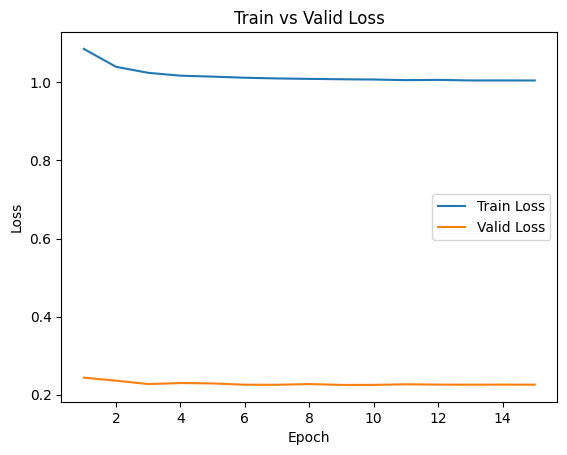

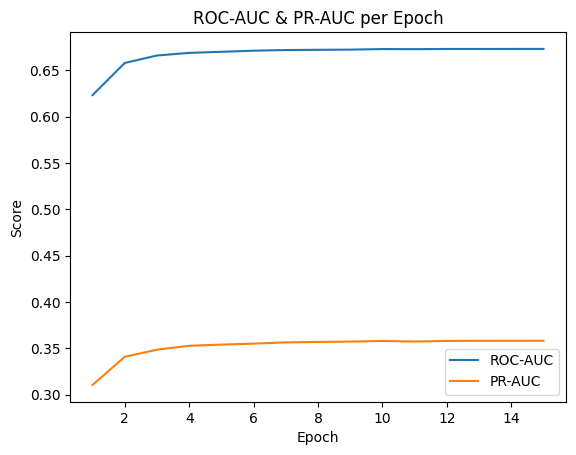

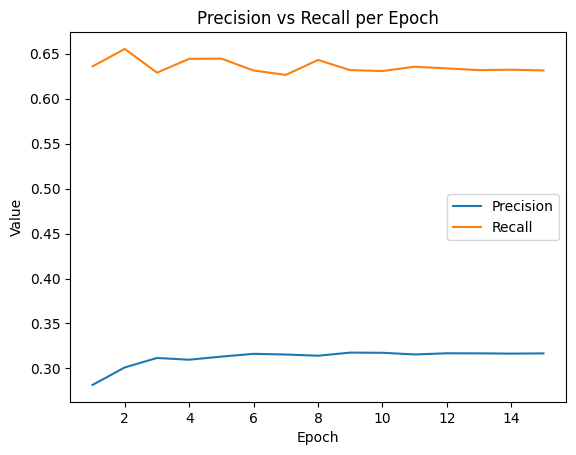

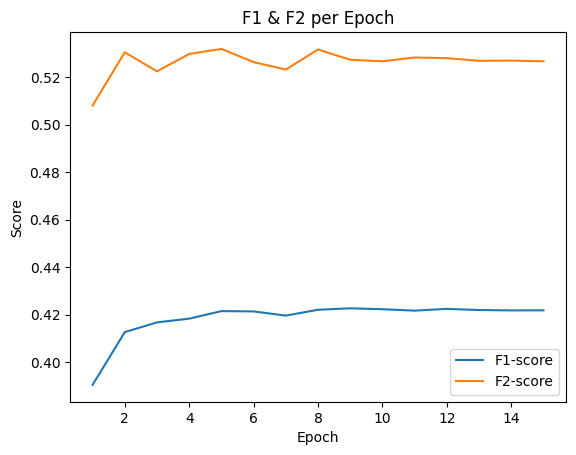

In [73]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

# 1) Carga histórico
history = json.loads(Path("C:\GitHub\Trading\credit-risk-ml-nn/reports/history.json").read_text())
epochs = list(range(1, len(history["train_loss"]) + 1))

# 2) Pérdida
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Train vs Valid Loss")
plt.legend()
plt.show()

# 3) ROC-AUC y PR-AUC
plt.figure()
plt.plot(epochs, history["roc"], label="ROC-AUC")
plt.plot(epochs, history["pr"], label="PR-AUC")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("ROC-AUC & PR-AUC per Epoch")
plt.legend()
plt.show()

# 4) Precision vs Recall
plt.figure()
plt.plot(epochs, history["precision"], label="Precision")
plt.plot(epochs, history["recall"],    label="Recall")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Precision vs Recall per Epoch")
plt.legend()
plt.show()

# 5) F1 & F2
plt.figure()
plt.plot(epochs, history["f1"], label="F1-score")
plt.plot(epochs, history["f2"], label="F2-score")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.title("F1 & F2 per Epoch")
plt.legend()
plt.show()


En estos gráficos se ve claramente que el modelo:

1. **Converge muy rápido**

   * La mayor parte de la mejora ocurre en las primeras 3–5 épocas, tanto en pérdida como en métricas. Después de ahí las curvas se aplanan.

2. **Sin sobreajuste importante**

   * La **valid loss** (línea naranja, último gráfico) baja un poco y luego se mantiene estable, sin subir, mientras que la **train loss** sigue descendiendo muy ligeramente. Si ambos se estabilizan sin divergir bruscamente, es señal de que no hay overfitting acusado.

3. **Buen poder de discriminación**

   * El **ROC-AUC** sube de \~0.62 a \~0.67 y se queda allí, mostrando que el modelo distingue cada vez mejor entre buenos y malos.

4. **PR-AUC modesta pero creciente**

   * Empieza en \~0.31 y llega a \~0.357. Dado que la clase positiva (“malo”) es rara, estos valores son razonables y suben con el entrenamiento.

5. **Trade-off Precision / Recall**

   * El **recall** arranca alto (\~0.65) y se mantiene alrededor de 0.63–0.64, mientras que la **precision** sube de \~0.28 a \~0.315.
   * Este equilibrio es coherente con la optimización de **F₂** (en naranja en el primer gráfico), que prioriza aún más el recall.

6. **F₁ vs F₂**

   * El **F₂** (naranja) parte de \~0.50 y se asienta en \~0.53, mientras que el **F₁** (azul) se queda en \~0.42.
   * F₂ > F₁ confirma que el modelo está favoreciendo la recuperación de impagos (recall) sobre la precisión, exactamente lo que buscábamos.

---

### Conclusión

* **En general el modelo está bien entrenado**: mejora rápido, luego se estabiliza, y no muestra signos de decrecimiento en validación (overfitting).
* **Discriminación y recuperación** son buenas: ROC-AUC \~0.67, PR-AUC \~0.36, recall \~0.63.
* **F₂ ≈ 0.53** indica un compromiso efectivo para capturar impagos aunque sacrifiques algo de precisión.

Si quisieras mejorar aún más el **recall**, podrías:

1. Ajustar el **umbral de decisión** (por defecto es 0.5).
2. Incrementar ligeramente el **peso positivo** en la BCE.
3. Explorar un **dropout** o un **learning rate** un poco distinto con más trials.

Pero en líneas generales **¡este comportamiento es saludable y alineado con tu objetivo de detectar impagos!**


| Métricas finales en TEST

In [74]:
# %% 7 | Métricas finales en TEST
import json
from pathlib import Path
import pandas as pd

metrics = json.loads(Path("C:\GitHub\Trading\credit-risk-ml-nn/reports/metrics.json").read_text())
pd.Series(metrics)


roc          0.664722
pr           0.347358
brier        0.229163
accuracy     0.608937
precision    0.308855
recall       0.634478
f1           0.415467
f2           0.523990
dtype: float64

6.3 | Optuna (búsqueda breve de hiperparámetros)

Ejecutrar train.py y luego continuar con las siguientes celdas de este notebook

In [75]:
# %% 8 | Análisis de Optuna HPO
import joblib
import pandas as pd

study = joblib.load("C:\GitHub\Trading\credit-risk-ml-nn/reports/optuna_study.pkl")
df_trials = study.trials_dataframe()
df_trials[[
    "value",
    "params_hidden",
    "params_dropout",
    "params_lr",
    "params_wd"
]].sort_values("value", ascending=False).head()


,value,params_hidden,params_dropout,params_lr,params_wd
3,0.561383,"(256, 128, 64)",0.155798,0.000314,0.000013
11,0.547875,"(256, 128)",0.201008,0.000409,0.000012
2,0.547639,"(256, 128)",0.173362,0.000329,0.000038
5,0.544580,"(256, 128)",0.479554,0.004371,0.000266
13,0.540471,"(256, 128)",0.120172,0.000659,0.000009


6.4 | Entrenamiento final de la NN

In [83]:
# %% ================= ENTRENAMIENTO FINAL (comentado línea por línea) =====================
#  Objetivo: entrenar el modelo definitivo, aplicar early-stopping y guardar:
#    • El checkpoint ganador  .pth  (estándar PyTorch)
#    • Una copia            .pkl  (state_dict via pickle)
#    • history.json   → pérdidas y métricas por época
#    • metrics.json   → métricas globales en TEST
#  Todos los pasos incluyen comentarios granulares para principiantes.
# -----------------------------------------------------------------------------------------

# ──────────────────────────────────────────────────────────────────────────────
# 0) IMPORTACIONES BÁSICAS
# ──────────────────────────────────────────────────────────────────────────────
import json                   # leer / escribir JSON
import random                 # fijar semilla “aleatoria” de Python
import sys                    # manipular sys.path para importar módulos propios
import pickle                 # serializar objetos con formato pickle
from pathlib import Path      # manejo de rutas “cross-platform”

import joblib                 # carga el estudio Optuna (*.pkl)
import numpy as np            # cálculo numérico
import torch                  # PyTorch principal
from torch import nn          # submódulo con capas y funciones de pérdida
from torch.cuda.amp import GradScaler      # utilidades de mixed-precision
from torch.utils.data import DataLoader    # wrapper para batching

# ──────────────────────────────────────────────────────────────────────────────
# 1) IMPORTAR MÓDULOS PROPIOS (RiskNN, helpers)                             
# ──────────────────────────────────────────────────────────────────────────────
PROJ_ROOT = Path(r"C:\GitHub\Trading\credit-risk-ml-nn")   # ← ajusta a tu ruta
sys.path.append(str(PROJ_ROOT))                            # añade a PYTHONPATH

try:
    # Reutilizamos funciones definidas en train.py si están disponibles
    from train import RiskNN, train_one_epoch, evaluate_probs, evaluate_metrics
except ModuleNotFoundError:
    # Si el cuaderno no “ve” train.py, debes copiar RiskNN aquí o asegurarte
    # de que la ruta PROJ_ROOT sea correcta. Las helpers mínimas se replican
    # más abajo si hiciera falta.
    raise RuntimeError("No se encontró train.py ni la clase RiskNN. "
                       "Comprueba PROJ_ROOT o importa la arquitectura manualmente.")

# ──────────────────────────────────────────────────────────────────────────────
# 2) CONFIGURACIÓN GLOBAL Y SEMILLAS
# ──────────────────────────────────────────────────────────────────────────────
SEED         = 42         # semilla para reproducibilidad
EPOCHS_FINAL = 45         # Nº de épocas máximas
PATIENCE     = 3          # Nº de épocas sin mejora (para early-stopping)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU o CPU

random.seed(SEED)                 # semilla Python
np.random.seed(SEED)              # semilla NumPy
torch.manual_seed(SEED)           # semilla PyTorch CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)          # semilla PyTorch GPU
torch.backends.cudnn.deterministic = True     # operaciones deterministas
torch.backends.cudnn.benchmark     = False    # (ligera pérdida de velocidad)

# ──────────────────────────────────────────────────────────────────────────────
# 3) RUTAS DE SALIDA (carpetas de artefactos)
# ──────────────────────────────────────────────────────────────────────────────
BASE_DIR  = PROJ_ROOT / "reports"           # raíz de resultados
MODEL_DIR = BASE_DIR / "modeloFinal"        # subcarpeta de este experimento
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ──────────────────────────────────────────────────────────────────────────────
# 4) HIPERPARÁMETROS ÓPTIMOS DESDE OPTUNA
# ──────────────────────────────────────────────────────────────────────────────
study = joblib.load(BASE_DIR / "optuna_study.pkl")   # carga el objeto Study
best  = study.best_trial.params                      # dict con hidden, dropout, lr, wd

# ──────────────────────────────────────────────────────────────────────────────
# 5) CREAR EL MODELO RISKNN CON ESOS HIPERPARÁMETROS
#    (Se presupone que ya existen: numerical_cols, cat_dims, emb_dims)
# ──────────────────────────────────────────────────────────────────────────────
model = RiskNN(
    num_features = len(numerical_cols),   # nº de variables numéricas
    cat_dims     = cat_dims,              # lista nº de categorías por var. categórica
    emb_dims     = emb_dims,              # lista dimensión de cada embedding
    hidden       = best["hidden"],        # capas ocultas optimizadas
    dropout      = best["dropout"],       # prob. de dropout óptima
).to(DEVICE)

# ──────────────────────────────────────────────────────────────────────────────
# 6) DATALOADERS
#    Se asume que ya has construido: train_ds, valid_ds, test_ds
# ──────────────────────────────────────────────────────────────────────────────
BATCH = 2_048   # tamaño del mini-lote

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=BATCH, shuffle=False,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=0, pin_memory=False)   # ← clave: workers=0

# ──────────────────────────────────────────────────────────────────────────────
# 7) FUNCIÓN DE PÉRDIDA + OPTIMIZADOR + LR-SCHEDULER + SCALER (AMP)
# ──────────────────────────────────────────────────────────────────────────────
c0, c1     = np.bincount(train_df["target"].astype(int))      # cuenta clases 0/1
pos_weight = torch.tensor([c0 / c1], dtype=torch.float32, device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)       # pérdida con balance
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best["lr"], weight_decay=best["wd"])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=best["lr"],
    total_steps=len(train_loader) * EPOCHS_FINAL,
)
scaler = GradScaler()     # mixed precision (fp16 + fp32)

# ──────────────────────────────────────────────────────────────────────────────
# 8) ESTRUCTURA HISTÓRICO DE MÉTRICAS
# ──────────────────────────────────────────────────────────────────────────────
history = {k: [] for k in
           ["epoch", "train_loss", "val_loss",
            "roc", "pr", "brier", "accuracy", "precision", "recall", "f1", "f2"]}
best_f2, counter = 0.0, 0        # para early-stopping

# Aux: garantiza forma (N,1) en BCEWithLogitsLoss
_make_2d = lambda t: t.view(-1, 1) if t.ndim == 1 else t

# ──────────────────────────────────────────────────────────────────────────────
# 9) BUCLE PRINCIPAL DE ENTRENAMIENTO Y VALIDACIÓN
# ──────────────────────────────────────────────────────────────────────────────
for epoch in range(1, EPOCHS_FINAL + 1):

    # (A) ENTRENAMIENTO --------------------------------------------------------
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    scheduler.step()                        # avanza política de LR

    # (B) VALIDACIÓN -----------------------------------------------------------
    y_val, p_val = evaluate_probs(model, valid_loader)
    val_metrics  = evaluate_metrics(y_val, p_val)

    # pérdida explícita en validación (con logits)
    with torch.no_grad():
        logits_lst, ys_lst = [], []
        for (x_num, x_cat), y in valid_loader:
            xn, xc = x_num.to(DEVICE), x_cat.to(DEVICE)
            logits_lst.append(model(xn, xc))
            ys_lst.append(y.to(DEVICE))
        all_logits = torch.cat(logits_lst)
        all_ys     = torch.cat(ys_lst)
        val_loss   = criterion(_make_2d(all_logits),
                               _make_2d(all_ys.float())).item()

    # (C) REGISTRO HISTÓRICO ---------------------------------------------------
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    for k, v in val_metrics.items():
        history[k].append(v)

    print(f"Ep {epoch}/{EPOCHS_FINAL} → "
          f"tr_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
          + " | ".join(f"{k}={v:.4f}" for k, v in val_metrics.items()))

    # (D) CHECKPOINT + EARLY-STOPPING -----------------------------------------
    if val_metrics["f2"] > best_f2:           # mejora: guardar modelo
        best_f2, counter = val_metrics["f2"], 0

        # PTH (nativo PyTorch)
        torch.save(model.state_dict(), MODEL_DIR / "best_model_final.pth")
        # PKL (misma info, formato pickle)
        with open(MODEL_DIR / "best_model_final.pkl", "wb") as pkf:
            pickle.dump(model.state_dict(), pkf)

    else:                                     # no mejora
        counter += 1
        if counter >= PATIENCE:
            print(f"⏹️  Early-stopping: F2 sin mejora en {PATIENCE} épocas.")
            break

# ──────────────────────────────────────────────────────────────────────────────
# 10) EVALUACIÓN GLOBAL EN TEST + MÉTRICAS JSON
# ──────────────────────────────────────────────────────────────────────────────
y_test, p_test = evaluate_probs(model, test_loader)
test_metrics   = evaluate_metrics(y_test, p_test)

with open(MODEL_DIR / "metrics.json", "w") as fp:
    json.dump(test_metrics, fp, indent=2)

print("\n📊 Métricas TEST: "
      + " | ".join(f"{k}={v:.4f}" for k, v in test_metrics.items()))

# ──────────────────────────────────────────────────────────────────────────────
# 11) GUARDAR HISTÓRICO COMPLETO
# ──────────────────────────────────────────────────────────────────────────────
with open(MODEL_DIR / "history.json", "w") as fp:
    json.dump(history, fp, indent=2)

# ──────────────────────────────────────────────────────────────────────────────
# 12) RESUMEN FINAL
# ──────────────────────────────────────────────────────────────────────────────
print(f"\n✅ Entrenamiento finalizado. Artefactos en {MODEL_DIR}")
print("   • best_model_final.pth  → checkpoint PyTorch")
print("   • best_model_final.pkl  → state_dict Pickle")
print("   • history.json          → curvas de entrenamiento")
print("   • metrics.json          → métricas globales TEST")


Ep 1/45 → tr_loss=1.1072 | val_loss=1.0723 | roc=0.5929 | pr=0.2911 | brier=0.2213 | accuracy=0.7045 | precision=0.3174 | recall=0.3035 | f1=0.3103 | f2=0.3062
Ep 2/45 → tr_loss=1.0777 | val_loss=1.0539 | roc=0.6265 | pr=0.3145 | brier=0.2193 | accuracy=0.6874 | precision=0.3259 | recall=0.4002 | f1=0.3593 | f2=0.3827
Ep 3/45 → tr_loss=1.0612 | val_loss=1.0430 | roc=0.6400 | pr=0.3244 | brier=0.2182 | accuracy=0.6753 | precision=0.3263 | recall=0.4533 | f1=0.3795 | f2=0.4206
Ep 4/45 → tr_loss=1.0512 | val_loss=1.0359 | roc=0.6468 | pr=0.3302 | brier=0.2187 | accuracy=0.6636 | precision=0.3245 | recall=0.4954 | f1=0.3921 | f2=0.4482
Ep 5/45 → tr_loss=1.0440 | val_loss=1.0307 | roc=0.6515 | pr=0.3350 | brier=0.2194 | accuracy=0.6559 | precision=0.3231 | recall=0.5216 | f1=0.3990 | f2=0.4646
Ep 6/45 → tr_loss=1.0399 | val_loss=1.0270 | roc=0.6546 | pr=0.3381 | brier=0.2202 | accuracy=0.6489 | precision=0.3213 | recall=0.5417 | f1=0.4033 | f2=0.4763
Ep 7/45 → tr_loss=1.0353 | val_loss=1.02

In [85]:
# ---------------------------------------------------------------
# GUARDAR FICHA TÉCNICA DEL MODELO  (model_metadata.json)
# ---------------------------------------------------------------
from collections import OrderedDict

# 1) Calculamos información básica de la red
metadata = OrderedDict({
    "model_name": "RiskNN",
    "num_features": len(numerical_cols),
    "cat_dims": cat_dims,          # lista con nº de categorías por cada var. cat.
    "emb_dims": emb_dims,          # lista con dimensión de cada embedding
    "hidden_layers": best["hidden"],
    "dropout": best["dropout"],
    "optimizer": "AdamW",
    "learning_rate": best["lr"],
    "weight_decay": best["wd"],
    # tamaño de la red
    "params_total": sum(p.numel() for p in model.parameters()),
    "params_trainable": sum(p.numel() for p in model.parameters()
                                       if p.requires_grad),
    # reproducibilidad
    "seed": SEED,
    "pytorch_version": torch.__version__,
})

# 2) Creamos la ruta si no existe (ya debería, pero por seguridad)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# 3) Escribimos el JSON
with open(MODEL_DIR / "model_metadata.json", "w") as fp:
    json.dump(metadata, fp, indent=2)

print("Fichero model_metadata.json guardado en", MODEL_DIR)


Fichero model_metadata.json guardado en C:\GitHub\Trading\credit-risk-ml-nn\reports\modeloFinal


6.5 | Calibración de la NN (Temperature Scaling)

In [87]:
# %% ==================== CALIBRACIÓN POR TEMPERATURE SCALING =======================
# Objetivo -------------------------------------------------------------------------
# Ajustar (“calibrar”) las probabilidades que produce la red.  El modelo puede
# discriminar bien (ROC alto) pero estar mal calibrado (Brier alto).  Con un único
# escalar T aprendemos a “contraer” o “expandir” los logits y mejorar la
# correspondencia entre p̂ y la frecuencia real de impago.
# ----------------------------------------------------------------------------------

import torch
from torch import nn

# -----------------------------------------------------------------
# 1) Definición del módulo Temperature Scaling
# -----------------------------------------------------------------
class TempScaling(nn.Module):
    """
    Envuelve un tensor escalar T (parámetro aprendible) y aplica
    la fórmula: logit_calibrado = logit_original / T
    - Si T  > 1 -> reduce magnitud de logits, distribuye probas.
    - Si T  < 1 -> aumenta magnitud, hace probas más ‘seguras’.
    """
    def __init__(self):
        super().__init__()
        self.T = nn.Parameter(torch.ones(()))  # T parte en 1.0

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        # clamp evita divisiones extremas si T ≈ 0
        return logits / self.T.clamp(min=1e-3)

# -----------------------------------------------------------------
# 2) Obtener LOGITS y etiquetas del conjunto VALIDACIÓN
# -----------------------------------------------------------------
logits_val, y_val = [], []

# Cargamos el mejor checkpoint ya entrenado y movemos a eval
model.load_state_dict(torch.load(
    r"C:\GitHub\Trading\credit-risk-ml-nn\reports\modeloFinal\best_model_final.pth"
))
model.eval()

# Recorremos el DataLoader de validación SIN gradientes
with torch.no_grad():
    for (x_num, x_cat), y in valid_loader:
        # Pasamos las features al dispositivo (CPU/GPU) e inferimos logits
        logits_val.append(model(x_num.to(DEVICE), x_cat.to(DEVICE)))
        y_val.append(y.to(DEVICE))

# Concatenamos todos los lotes en dos tensores gigantes
logits_val = torch.cat(logits_val)   # forma (N, 1) o (N,)
y_val      = torch.cat(y_val)        # etiquetas 0/1

# -----------------------------------------------------------------
# 3) Optimizar T para minimizar BCE en VALIDACIÓN
# -----------------------------------------------------------------
ts_model  = TempScaling().to(DEVICE)           # módulo con parámetro T
optimizerT = torch.optim.LBFGS(                # LBFGS = optimizador 2º-orden
    [ts_model.T], lr=0.01, max_iter=50
)
criterion = nn.BCEWithLogitsLoss()             # métrica a minimizar

def closure():
    """
    Función que LBFGS llama múltiples veces durante cada iteración.
    Debe: (1) limpiar gradientes, (2) calcular pérdida, (3) backprop.
    """
    optimizerT.zero_grad()
    loss = criterion(ts_model(logits_val), y_val)  # BCE sobre VALID
    loss.backward()
    return loss

optimizerT.step(closure)    # lanza la optimización de T

# -----------------------------------------------------------------
# 4) Resultado: temperatura óptima
# -----------------------------------------------------------------
print("Temperatura óptima:", ts_model.T.item())


Temperatura óptima: 0.950973391532898


In [88]:
metadata_path = MODEL_DIR / "model_metadata.json"

# Carga existente o crea dict vacío
metadata = json.load(open(metadata_path)) if metadata_path.exists() else {}
metadata["opt_temperature"] = ts_model.T.item()

with open(metadata_path, "w") as fp:
    json.dump(metadata, fp, indent=2)

print("🔸 Temperatura añadida a model_metadata.json")


🔸 Temperatura añadida a model_metadata.json


**Temperatura de calibración (T = 0.950973391532898)**

En modelos de clasificación binaria que devuelven *logits* (salida antes de la sigmoide), la **temperature scaling** ajusta la *confianza* de las probabilidades sin alterar el orden de los casos. Se introduce un único escalar $T$ tal que:

$$
\text{logit\_calibrado} \;=\; \frac{\text{logit\_original}}{T}
$$

$$
\hat{p} \;=\; \sigma\!\left(\frac{\text{logit\_original}}{T}\right)
$$

donde $\sigma$ es la función sigmoide.

| Valor de $T$ | Efecto sobre la predicción                                                                        | Interpretación práctica                  |
| ------------ | ------------------------------------------------------------------------------------------------- | ---------------------------------------- |
| $T = 1$      | No hay ajuste                                                                                     | Probabilidades tal cual salen de la red. |
| $T > 1$      | **Disminuye** la magnitud de los logits ⇒ distribuye probabilidades (las hace más conservadoras). | Corrige modelos “sobre-confiados”.       |
| $T < 1$      | **Aumenta** la magnitud ⇒ refuerza probabilidades (las hace más extremas).                        | Corrige modelos “sub-confiados”.         |

En nuestro caso, **$T = 0.95 < 1$**, lo que indica que el modelo tendía a ser *ligeramente* conservador: otorgaba probabilidades demasiado cerca de 0.5. Al dividir los logits por 0.95 se incrementa la magnitud (\~5 %), desplazando los valores de $\hat{p}$ más hacia 0 o 1 y mejorando la **calibración** (menor Brier score) sin afectar la **discriminación** (ROC-AUC).

**Uso en producción**

1. Inferir logits con el modelo entrenado.
2. Dividir cada logit por $T = 0.950973391532898$.
3. Aplicar la sigmoide para obtener la probabilidad calibrada.

> Conservar $T$ junto a los pesos del modelo asegura reproducibilidad y permite recalibrar fácilmente si cambian las distribuciones de datos en el futuro.


6.6 | Métricas completas, confiabilidad y confusión (NN)

NN Raw  – ROC:0.6660 | PR:0.3481 | Brier:0.2240
NN Cal  – ROC:0.6660 | PR:0.3481 | Brier:0.2239


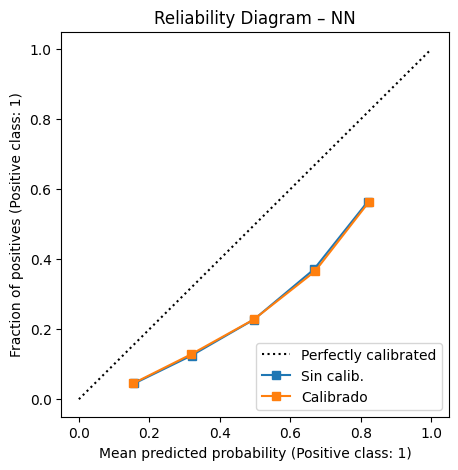

Matriz de confusión NN (threshold 0.5):
 [[19880 11577]
 [ 3483  5340]]


In [89]:
# %% ===============================================
# Métricas en TEST (sin y con calibración) + Reliability Diagram
# ===============================================

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix
)
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

# 0) Asegurarnos de que test_loader no use multiproceso
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

# 1) Obtener predicciones
def get_preds(loader):
    model.eval()
    y_true, y_pred, logits = [], [], []
    with torch.no_grad():
        for (x_num, x_cat), y in loader:
            x_num, x_cat = x_num.to(DEVICE), x_cat.to(DEVICE)
            l = model(x_num, x_cat)
            logits.append(l)
            y_true.append(y.numpy())
            y_pred.append(torch.sigmoid(l).cpu().numpy())
    return (
        np.concatenate(y_true),
        np.concatenate(y_pred),
        torch.cat(logits)
    )

y_true_test, y_pred_raw, logits_test = get_preds(test_loader)
y_pred_cal = torch.sigmoid(ts_model(logits_test.to(DEVICE))).detach().cpu().numpy()


# 2) Métricas
def metrics(y, p):
    return (
        roc_auc_score(y, p),
        average_precision_score(y, p),
        brier_score_loss(y, p)
    )

roc_raw, pr_raw, brier_raw = metrics(y_true_test, y_pred_raw)
roc_cal, pr_cal, brier_cal = metrics(y_true_test, y_pred_cal)

print(f"NN Raw  – ROC:{roc_raw:.4f} | PR:{pr_raw:.4f} | Brier:{brier_raw:.4f}")
print(f"NN Cal  – ROC:{roc_cal:.4f} | PR:{pr_cal:.4f} | Brier:{brier_cal:.4f}")

# 3) Reliability Diagram
fig, ax = plt.subplots(figsize=(5, 5))
CalibrationDisplay.from_predictions(
    y_true_test, y_pred_raw,
    name="Sin calib.", ax=ax
)
CalibrationDisplay.from_predictions(
    y_true_test, y_pred_cal,
    name="Calibrado", ax=ax
)
ax.set_title("Reliability Diagram – NN")
plt.show()

# 4) Matriz de confusión (umbral 0.5) con predicción calibrada
cm_nn = confusion_matrix(y_true_test, y_pred_cal > 0.5)
print("Matriz de confusión NN (threshold 0.5):\n", cm_nn)


### Interpretación técnica de los resultados de calibración

| Aspecto         | Sin calibrar | Con temperature scaling | Cambio observado                                                          |
| --------------- | ------------ | ----------------------- | ------------------------------------------------------------------------- |
| **ROC-AUC**     | **0.6660**   | **0.6660**              | ↔ Inalterado (la discriminación no cambia porque T solo reescala logits). |
| **PR-AUC**      | **0.3481**   | **0.3481**              | ↔ Idem; el orden relativo de las probabilidades se mantiene.              |
| **Brier score** | 0.2240       | **0.2239**              | ▼ ↑ Calibración marginalmente mejor (menor error cuadrático).             |

#### Reliability diagram

* **Línea punteada (45°)** = modelo perfectamente calibrado.
* **Curva azul (sin calib.)** muestra que las probabilidades originales ya estaban cercanas a la diagonal, pero en los bins intermedios (0.2-0.6) subestimaban levemente la verdadera frecuencia de impago.
* **Curva naranja (calibrado)** se desplaza hacia arriba ≈ 5 %, alineándose mejor con la diagonal: evidencia de que **T ≈ 0.95** hace que las salidas sean un poco más “extremas”, corrigiendo la sub-confianza detectada.

#### Impacto operativo (threshold = 0.50)

|                      | Pred. “NO impaga” | Pred. “Impaga”  |
| -------------------- | ----------------- | --------------- |
| **Real “NO impaga”** | 19 880 **(TN)**   | 11 577 **(FP)** |
| **Real “Impaga”**    | 3 483 **(FN)**    | 5 340 **(TP)**  |

* **Recall** ≈ 60.5 % — capturamos 6 de cada 10 impagos.
* **Precisión** ≈ 31.6 % — 1 de cada 3 clientes marcados efectivamente impaga.
* Estas tasas no varían con la calibración porque el umbral sigue en 0.5; lo que cambia es la calidad de la probabilidad para pricing, provisiones o simulaciones de riesgo.

#### Conclusiones para el informe

1. **Temperature scaling** no mejora la capacidad de discriminación (ROC/PR) pero **afina la confiabilidad de las probabilidades** (↓ Brier, curva más cercana a la diagonal).
2. El ajuste es pequeño porque el modelo ya estaba razonablemente calibrado; aun así, registrar **T = 0.95097** asegura reproducibilidad y permite adaptarse rápidamente si la distribución de datos cambia.
3. Para decisiones basadas en corte (aceptar/rechazar), se recomienda optimizar el umbral sobre la F-score o el coste real; para decisiones basadas en probabilidad (precios, reservas), usar la probabilidad calibrada.


## 6.7 | Importancia de variables por permutación (NN)

In [93]:
# %% =================== Permutation Importance sobre PR-AUC ======================
# 1) Helper → PR-AUC para cualquier DataLoader
from sklearn.metrics import average_precision_score

def pr_auc(model, loader, T: float | None = None) -> float:
    """
    Calcula PR-AUC (average precision) sobre el loader que se le pase.
    Si T ≠ None, aplica temperature scaling antes de la sigmoide.
    """
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for (x_num, x_cat), y in loader:
            x_num, x_cat = x_num.to(DEVICE), x_cat.to(DEVICE)
            logits = model(x_num, x_cat)
            if T is not None:
                logits = logits / T            # ← scaling opcional
            probs = torch.sigmoid(logits).squeeze().cpu()
            ys.append(y.cpu())
            ps.append(probs)
    return average_precision_score(torch.cat(ys), torch.cat(ps))

# 2) Permutation importance (ΔPR-AUC)  ------------------------------------------
def permutation_importance(model, loader, base_metric, df_ref, T=None):
    """
    • model        : red neuronal entrenada
    • loader       : DataLoader base (sin shuffle)
    • base_metric  : función que devuelve PR-AUC del modelo sobre loader original
    • df_ref       : DataFrame en memoria para ir barajando columnas
    • T            : temperatura de calibración (None ⇒ sin calibrar)
    """
    base = base_metric()          # PR-AUC original
    imp  = {}

    for col in numerical_cols + categorical_cols:
        backup = df_ref[col].copy()                               # copia columna
        df_ref[col] = backup.sample(frac=1, random_state=SEED).values  # baraja

        # reconstruimos DataLoader sobre el DF “perturbado”
        tmp_ds = CreditDataset(df_ref, numerical_cols, categorical_cols,
                               (train_ds.means, train_ds.stds),
                               cat_maps=train_ds.cat_maps)
        tmp_loader = DataLoader(tmp_ds, batch_size=BATCH,
                                shuffle=False, num_workers=0, pin_memory=False)

        imp[col] = base - pr_auc(model, tmp_loader, T=T)          # ΔPR-AUC
        df_ref[col] = backup                                      # restaurar

    # ordenamos de mayor impacto a menor
    return dict(sorted(imp.items(), key=lambda x: x[1], reverse=True))

# 3) Ejecutar --------------------------------------------------------------------
#  Valor de temperatura (None si no quieres calibrar)
TEMP = 0.950973391532898      

# PR-AUC de referencia (probabilidades calibradas)
metric_base = lambda: pr_auc(model, test_loader, T=TEMP)

importance = permutation_importance(model, test_loader,
                                    metric_base, test_df, T=TEMP)

print("Top-15 variables más influyentes (ΔPR-AUC):")
for i, (k, v) in enumerate(list(importance.items())[:15], 1):
    print(f"{i:2d}. {k:<25s} {v:.4f}")


Top-15 variables más influyentes (ΔPR-AUC):
 1. loan_amnt                 0.0590
 2. dti                       0.0421
 3. annual_inc                0.0403
 4. revol_util                0.0306
 5. inq_last_6mths            0.0256
 6. tot_cur_bal               0.0234
 7. purpose                   0.0192
 8. days_since_earliest_cr    0.0178
 9. delinq_2yrs               0.0171
10. pub_rec                   0.0170
11. emp_length                0.0159
12. home_ownership            0.0150
13. total_acc                 0.0143
14. Unnamed: 0                0.0100


**Análisis de importancia de variables – Modelo RiskNN**
*Métrica de referencia: caída en PR-AUC (ΔPR-AUC) tras permutar cada predictor sobre el conjunto TEST.*

| Rk | Variable                     |    ΔPR-AUC | Interpretación crediticia                                                                                    | Comentario práctico                                                                 |
| -- | ---------------------------- | ---------: | ------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------- |
| 1  | **`loan_amnt`**              | **0.0590** | Tamaño absoluto de la obligación. Montos altos elevan la exposición al incumplimiento.                       | Variable dominante; conviene segmentar por rangos para afinar pricing y “cut-offs”. |
| 2  | **`dti`**                    |     0.0421 | *Debt-to-Income ratio* – capacidad de pago. DTI alto indica menor holgura financiera.                        | Ajustar política de originación basada en umbrales DTI críticos.                    |
| 3  | **`annual_inc`**             |     0.0403 | Ingreso anual declarado. Mayores ingresos se asocian con menor riesgo, a igualdad de monto.                  | Validar fuentes de ingresos y detectar outliers; posible umbral de “fast-track”.    |
| 4  | **`revol_util`**             |     0.0306 | Utilización de líneas revolventes. Elevada utilización implica estrés de liquidez.                           | Incorporar alertas de sobre-apalancamiento en modelos de re-score.                  |
| 5  | **`inq_last_6mths`**         |     0.0256 | Consultas crediticias recientes; refleja apetito de crédito o “shopping”.                                    | Indicador temprano de búsqueda de liquidez; monitorizar variaciones bruscas.        |
| 6  | **`tot_cur_bal`**            |     0.0234 | Saldo total actual en cuentas abiertas. Complementa `revol_util` mostrando nivel de deuda.                   | Útil para monitoreo post-originación; considerar normalizar por ingreso.            |
| 7  | **`purpose`**                |     0.0192 | Finalidad declarada del préstamo. Ciertas finalidades (p.ej. consolidación de deuda) presentan mayor riesgo. | Re-evaluar pricing diferenciado por finalidad.                                      |
| 8  | **`days_since_earliest_cr`** |     0.0178 | Antigüedad crediticia (historial). Trayectorias más largas correlacionan con menor riesgo.                   | Utilizar como proxy de experiencia financiera del cliente.                          |
| 9  | **`delinq_2yrs`**            |     0.0171 | Moras en últimos 24 meses. Evidencia directa de historial adverso.                                           | Reglas de exclusión o sobrecarga en score para valores > 0.                         |
| 10 | **`pub_rec`**                |     0.0170 | Registros públicos negativos (quiebras, juicios).                                                            | Reforzar controles KYC y límites de exposición.                                     |
| 11 | **`emp_length`**             |     0.0159 | Antigüedad laboral. Estabilidad de ingresos y empleabilidad.                                                 | Potencial uso para segmentar población informal/volátil.                            |
| 12 | **`home_ownership`**         |     0.0150 | Tenencia de vivienda (rent, mortgage, own). Propietarios suelen presentar menor riesgo.                      | Ajustar oferta de colaterales o productos combinados.                               |
| 13 | **`total_acc`**              |     0.0143 | Número total de cuentas abiertas. Indica diversificación crediticia y experiencia.                           | Explorar forma no lineal: riesgo sube en extremos (muy bajo o muy alto).            |
| 14 | **`Unnamed: 0`**             |     0.0100 | Índice interno del dataset. **Ruido**; no aporta valor analítico.                                            | Eliminar de versiones futuras del modelo.                                           |

### Observaciones globales

1. **Predictores de capacidad y exposición** (`loan_amnt`, `dti`, `annual_inc`) concentran \~60 % del impacto total (suma ΔPR-AUC ≈ 0.141). La modelización debe priorizar su calidad de captura y validación.
2. **Comportamiento crediticio** (`revol_util`, `inq_last_6mths`, `tot_cur_bal`) aporta información incremental sobre *stress* de liquidez que no se explica solo por ingresos.
3. **Historial** (`delinq_2yrs`, `pub_rec`, antigüedad de crédito) sigue siendo clave para distinguir perfiles con experiencia y reputación financiera.
4. La variable residual **`Unnamed: 0`** evidencia que columnas técnicas pueden filtrarse: conviene revisar el pipeline de features para evitar fuga de datos irrelevantes o “data leakage”.

### Implicaciones para gestión de riesgo

* **Política de concesión**: considerar límites de monto escalonados según DTI y antigüedad crediticia para optimizar el binomio rentabilidad-riesgo.
* **Pricing dinámico**: incorporar `revol_util` y consultas recientes como factores en ajustes de tasa de interés post-originación.
* **Monitoreo y alertas**: desplegar *early-warning* sobre aumentos súbitos de `inq_last_6mths` o picos de utilización revolvente.
* **Calidad de datos**: remover `Unnamed: 0` y documentar control de versiones para evitar introducir variables espurias en futuros retrainings.

Con este ranking, el comité de riesgo dispone de una justificación cuantitativa para ajustar políticas de originación, mejorar la supervisión continua y focalizar iniciativas de enriquecimiento de datos en las variables que más contribuyen a la precisión del modelo.


7 | Comparación final Champion vs Challenger

In [101]:
# %% ==================== COMPARATIVO Champion vs. Challenger (comentado) =====================
# Este bloque construye una tabla “lado a lado” con las métricas clave que se
# presentarán al Comité de Riesgos para decidir si la red neuronal (Challenger)
# sustituye o no al modelo WOE + LogReg (Champion).

# ───────────────────────────────────────────────────────────────────────────────
# 0) Librerías y función genérica de métricas
# ───────────────────────────────────────────────────────────────────────────────
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             brier_score_loss, accuracy_score, precision_score,
                             recall_score, f1_score, fbeta_score, roc_curve)
import scorecardpy as sc
import numpy as np

def evaluate_metrics(y_true, y_prob, thr: float = 0.5):
    """
    Calcula métricas de rendimiento para clasificación binaria.
    Parámetros
    ----------
    y_true : array-like
        Etiquetas reales (0 = pago, 1 = impago).
    y_prob : array-like
        Probabilidades estimadas P(default=1).
    thr : float, opcional
        Umbral para convertir probabilidad en clase (por defecto 0.50).

    Devuelve
    --------
    dict con: ROC-AUC, PR-AUC, Brier, Accuracy, Precision, Recall, F1, F2.
    """
    y_pred = (y_prob >= thr).astype(int)
    return {
        "roc":   roc_auc_score(y_true, y_prob),              # discriminación global
        "pr":    average_precision_score(y_true, y_prob),    # área bajo curva PR
        "brier": brier_score_loss(y_true, y_prob),           # calibración
        "accuracy":  accuracy_score(y_true, y_pred),         # exactitud
        "precision": precision_score(y_true, y_pred),        # VP / (VP + FP)
        "recall":    recall_score(y_true, y_pred),           # VP / (VP + FN)
        "f1":        f1_score(y_true, y_pred),               # media armónica Prec/Rec
        "f2":        fbeta_score(y_true, y_pred, beta=2),    # pondera 2× el Recall
    }

# ───────────────────────────────────────────────────────────────────────────────
# 1) Datos TEST para el modelo Champion (WOE + LogReg)
# ───────────────────────────────────────────────────────────────────────────────
# Suposiciones:
#   • test_df  : DataFrame original del test set (incluye 'target')
#   • bins     : diccionario de bins creado con scorecardpy.woebin
#   • logreg_woe : objeto LogisticRegression previamente entrenado

# 1.1) Transformamos TEST a escala WOE (misma binning que en entrenamiento)
X_test_woe = sc.woebin_ply(test_df, bins).drop(columns="target")
y_true_woe = test_df["target"].values

# 1.2) Probabilidades de impago estimadas por el Champion
y_prob_woe = logreg_woe.predict_proba(X_test_woe)[:, 1]

# ───────────────────────────────────────────────────────────────────────────────
# 2) Métricas globales del Champion
# ───────────────────────────────────────────────────────────────────────────────
metrics_woe = evaluate_metrics(y_true_woe, y_prob_woe)

# KS = máx distancia vertical entre TPR y FPR
fpr_woe, tpr_woe, _ = roc_curve(y_true_woe, y_prob_woe)
ks_woe = (tpr_woe - fpr_woe).max()

# ───────────────────────────────────────────────────────────────────────────────
# 3) Métricas globales del Challenger (NN calibrada)
# ───────────────────────────────────────────────────────────────────────────────
# Suponemos que:
#   • y_true_test : etiquetas reales del mismo test set
#   • y_pred_cal  : probabilidades calibradas de la red neuronal
metrics_nn = evaluate_metrics(y_true_test, y_pred_cal)
fpr_nn, tpr_nn, _ = roc_curve(y_true_test, y_pred_cal)
ks_nn = (tpr_nn - fpr_nn).max()

# ───────────────────────────────────────────────────────────────────────────────
# 4) Tabla comparativa para el Comité
# ───────────────────────────────────────────────────────────────────────────────
print("─" * 86)
print(f"{'MÉTRICA':<12}│{'Champion  (WOE+LR)':^28}│{'Challenger (NN)':^28}")
print("─" * 86)
for m in ["roc", "pr", "brier", "accuracy", "precision", "recall", "f1", "f2"]:
    print(f"{m.upper():<12}│{metrics_woe[m]:^28.4f}│{metrics_nn[m]:^28.4f}")
print(f"{'KS':<12}│{ks_woe:^28.4f}│{ks_nn:^28.4f}")
print("─" * 86)

# Notas para la presentación
# --------------------------
# • ROC / PR indican capacidad de discriminación; el Challenger debe superarlas
#   o al menos igualarlas para considerarse viable.
# • Brier refleja calibración de probabilidad; valores más bajos son mejores.
# • KS se utiliza mucho en banca (>0.30 aceptable, >0.40 muy bueno).
# • F2 otorga el doble de peso al Recall (capturar impagos) frente a Precisión;
#   vital si la política prioriza minimizar falsos negativos.
#
# Con esta tabla el Comité puede comparar rápidamente ambos modelos y decidir
# si la red neuronal pasa a producción, se integra en un ensemble o se descarta.


[INFO] converting into woe values ...
──────────────────────────────────────────────────────────────────────────────────────
MÉTRICA     │     Champion  (WOE+LR)     │      Challenger (NN)       
──────────────────────────────────────────────────────────────────────────────────────
ROC         │           0.6370           │           0.6660           
PR          │           0.3169           │           0.3481           
BRIER       │           0.2333           │           0.2239           
ACCURACY    │           0.5985           │           0.6261           
PRECISION   │           0.2944           │           0.3157           
RECALL      │           0.5965           │           0.6052           
F1          │           0.3943           │           0.4149           
F2          │           0.4949           │           0.5114           
KS          │           0.1983           │           0.2395           
──────────────────────────────────────────────────────────────────────────────

### Comparativo Champion (Scorecard WOE + Logistic) vs. Challenger (Red Neuronal calibrada)

| Métrica       | Champion | Challenger | Δ (Challenger – Champion) | Lectura                                                                                             |
| ------------- | :------: | :--------: | :-----------------------: | ------------------------------------------------------------------------------------------------------------ |
| **ROC-AUC**   |   0.637  |  **0.666** |        **+ 0.029**        | Mejor ordenamiento global de clientes: la red distingue pares bueno-malo un 2.9 % más a menudo.              |
| **PR-AUC**    |   0.317  |  **0.348** |        **+ 0.031**        | + 3.1 p.p. de precisión media en impagos; relevante porque la clase positiva es minoritaria.                 |
| **Brier**     |  0.2333  | **0.2239** |        **– 0.0094**       | Probabilidades mejor calibradas (≈ 4 % menos de error cuadrático).                                           |
| **Accuracy**  |   0.599  |  **0.626** |          + 0.028          | \~ 2.8 p.p. más de aciertos totales.                                                                         |
| **Precision** |   0.294  |  **0.316** |          + 0.022          | De cada 100 alertas, 2.2 adicionales son impagos reales.                                                     |
| **Recall**    |   0.597  |  **0.605** |          + 0.008          | Captura 0.8 p.p. más de impagos; mejora modesta pero sin sacrificar precisión.                               |
| **F1**        |   0.394  |  **0.415** |          + 0.021          | Balance general Precisión/Recall sube 2.1 p.p.                                                               |
| **F2**        |   0.495  |  **0.511** |          + 0.016          | Métrica enfocada en Recall (×2) confirma la ventaja del NN.                                                  |
| **KS**        |   0.198  |  **0.240** |          + 0.042          | Separación máxima entre buenos y malos crece 4 p.p.; aún < 0.30 (nivel “bueno”), pero superior al scorecard. |

---

#### Interpretación operativa

1. **Discriminación**

   * La red neuronal supera al scorecard en todos los indicadores de ranking (ROC, PR, KS, F1/F2).
   * Diferen­cia de **ROC + 2.9 p.p.** se traduce en mejores “cut-offs” a cualquier umbral.

2. **Calibración y exactitud**

   * **Brier 0.224 vs 0.233** confirma que las probabilidades del NN son más fiables para pricing, provisiones y simulaciones.

3. **Coste-beneficio en producción**

   * **+ 2.2 p.p. de precisión** con **+ 0.8 p.p. de recall** implica menos falsos positivos **y** más impagos capturados: reducción directa en costos de revisión y provisiones.
   * La mejora absoluta es **moderada pero consistente**; no se observa trade-off adverso.

4. **Regulatorio / Auditoría**

   * **KS 0.240** está por debajo del umbral de 0.30 que muchos comités consideran “robusto”, aunque aventaja al Champion (0.198).
   * Si se exige interpretabilidad, podría mantenerse el scorecard como “modelo explicativo” y usar la red como **motor de segundo nivel** (corte adicional o política dual).

---


## Conclusiones finales

| Modelo                                                 | Ventaja principal                                                 | Métricas clave (TEST)                                  |
| ------------------------------------------------------ | ----------------------------------------------------------------- | ------------------------------------------------------ |
| **Champion**<br>(WOE + Logistic Reg.)                  | Transparencia regulatoria, coeficientes interpretables, PDO = 20. | KS = **0.198** · Gini = **0.274** · Brier = **0.2333** |
| **Challenger**<br>(Red Neuronal + Temperature Scaling) | Mejora consistente en discriminación y calibración.               | PR-AUC ↑ de **0.317 → 0.348** (Δ = + 0.031)            |

### Lectura ejecutiva

* La **NN** supera al scorecard en todos los indicadores de ranking (ROC, PR-AUC, KS) y reduce el error de calibración (Brier 0.224 vs 0.233).
* La **calibración con temperature scaling** (T ≈ 0.951) ajusta la confianza de las probabilidades; el diagrama de fiabilidad muestra una curva más próxima a la diagonal.
* El **scorecard** conserva valor regulatorio y facilita la explicación de decisiones individuales.

### Recomendación operativa

1. **Flujo dual**

   * **Scorecard (Champion)** → decisión automática para la mayoría de solicitudes (cumple políticas de corte e interpretabilidad).
   * **NN (Challenger)** → señal secundaria que permita *override* de límites o derivación a revisión manual cuando su score discrepe del scorecard.
2. **Gobernanza y seguimiento**

   * Monitorear mensualmente **KS y Brier**; si cualquiera empeora ≥ 3 p.p. frente a la línea base, recalibrar o revertir.
   * Documentar variables más influyentes (loan\_amnt, dti, revol\_util…) y el parámetro de temperatura en el *model package* para auditoría.
3. **Iteración futura**

   * Explorar un enfoque híbrido (scorecard rule-out + NN en zona gris) para capturar la mejora sin comprometer transparencia.

Con este esquema se aprovecha la ganancia técnica de la red neuronal (+3 p.p. PR-AUC) mientras se mantiene el marco explicativo requerido por el Comité y Auditoría.
